# <a>Project 6 - Transfer Learning with Tensorflow</a>

## Let's Data - Data Science Journey

*By Reginaldo Jr - <a>reginaldojr@yahoo.com</a>*

### Imports and Configurations

In [27]:
import tensorflow as tf
import os
import shutil
import numpy as np
import PIL
import gradio as gr

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image

### Data

In [28]:
base_path = './data'
classes = os.listdir(os.path.join(base_path, "raw"))
classes

['carrot', 'lemon', 'potato', 'tomato']

In [29]:
processed_path = os.path.join(base_path, "processed")
if not os.path.exists(processed_path):
    os.makedirs(processed_path)
else:
    print("Processed folder already exists.")

Processed folder already exists.


In [30]:
train_folder = os.path.join(processed_path, "train")
val_folder = os.path.join(processed_path, "val")
test_folder = os.path.join(processed_path, "test")

if not os.path.exists(train_folder):
    os.makedirs(train_folder)
else:
    print("Train folder already exists.")
    
if not os.path.exists(val_folder):
    os.makedirs(val_folder)
else:
    print("Validation folder already exists.")
    
if not os.path.exists(test_folder):
    os.makedirs(test_folder)
else:
    print("Test folder already exists.")

Train folder already exists.
Validation folder already exists.
Test folder already exists.


In [31]:
folders = [train_folder, val_folder, test_folder]
for cl in classes:
    for folder in folders:
        dir_cl = os.path.join(folder,cl)
        if not os.path.exists(dir_cl):
            os.makedirs(dir_cl)
              
    files_in_class = os.listdir(os.path.join(base_path, "raw",cl))
    train, test = train_test_split(files_in_class, test_size=.2, random_state=42)
    val, test = train_test_split(test, test_size=.5, random_state=42)
    print(cl, len(train),len(val),len(test))
    print("Coping...")
    for i,files in enumerate((train, val, test)):
        folder = folders[i]
        for file in files:
            source = os.path.join(os.path.join(base_path, "raw"), cl, file)
            target = os.path.join(folder, cl, file)            
            shutil.copy(source, target)
print("Done!")

carrot 144 18 19
Coping...
lemon 88 11 12
Coping...
potato 116 15 15
Coping...
tomato 85 11 11
Coping...
Done!


### Model

In [32]:
image_size=100
batch_size = 32
num_epochs = 15

In [33]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [34]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               1179904   
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15928004 (60.76 MB)
Trainable params: 1213316 (4.63 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [35]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_folder, target_size=(image_size, image_size), batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_folder, target_size=(image_size, image_size), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(image_size, image_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=True
)


Found 433 images belonging to 4 classes.
Found 55 images belonging to 4 classes.
Found 57 images belonging to 4 classes.


In [36]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=num_epochs)

Epoch 1/15
14/14 [==============================] - 33s 2s/step - loss: 1.2381 - accuracy: 0.4527 - val_loss: 0.9532 - val_accuracy: 0.6364
Epoch 2/15
14/14 [==============================] - 39s 3s/step - loss: 0.8803 - accuracy: 0.6975 - val_loss: 0.7547 - val_accuracy: 0.7273
Epoch 3/15
14/14 [==============================] - 35s 2s/step - loss: 0.6733 - accuracy: 0.8176 - val_loss: 0.6050 - val_accuracy: 0.7636
Epoch 4/15
14/14 [==============================] - 34s 2s/step - loss: 0.5441 - accuracy: 0.8430 - val_loss: 0.5058 - val_accuracy: 0.8000
Epoch 5/15
14/14 [==============================] - 36s 3s/step - loss: 0.4700 - accuracy: 0.8453 - val_loss: 0.4597 - val_accuracy: 0.8545
Epoch 6/15
14/14 [==============================] - 38s 3s/step - loss: 0.3974 - accuracy: 0.8891 - val_loss: 0.3880 - val_accuracy: 0.8727
Epoch 7/15
14/14 [==============================] - 30s 2s/step - loss: 0.3338 - accuracy: 0.9099 - val_loss: 0.3532 - val_accuracy: 0.8727
Epoch 8/15
14/14 [==

In [37]:
history.history

{'loss': [1.2381141185760498,
  0.8803368210792542,
  0.6733003854751587,
  0.5441314578056335,
  0.4700116217136383,
  0.3974396288394928,
  0.33384495973587036,
  0.29745498299598694,
  0.2798468768596649,
  0.24775882065296173,
  0.21865513920783997,
  0.21460430324077606,
  0.19068747758865356,
  0.17379561066627502,
  0.16360563039779663],
 'accuracy': [0.4526558816432953,
  0.6974595785140991,
  0.8175519704818726,
  0.8429561257362366,
  0.8452655673027039,
  0.8891454935073853,
  0.9099307060241699,
  0.9099307060241699,
  0.9214780330657959,
  0.9284064769744873,
  0.9445727467536926,
  0.9307159185409546,
  0.9561200737953186,
  0.9584295749664307,
  0.9584295749664307],
 'val_loss': [0.9532490968704224,
  0.7547426223754883,
  0.6049843430519104,
  0.5057689547538757,
  0.4597007632255554,
  0.3880009651184082,
  0.35317444801330566,
  0.30476364493370056,
  0.30680665373802185,
  0.2787958085536957,
  0.26964476704597473,
  0.24282868206501007,
  0.22650159895420074,
  0.21

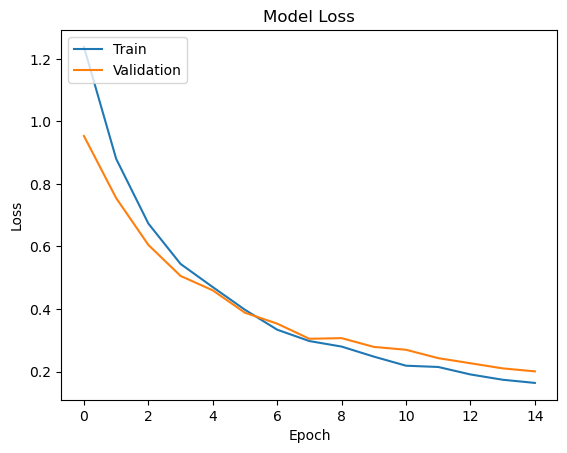

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

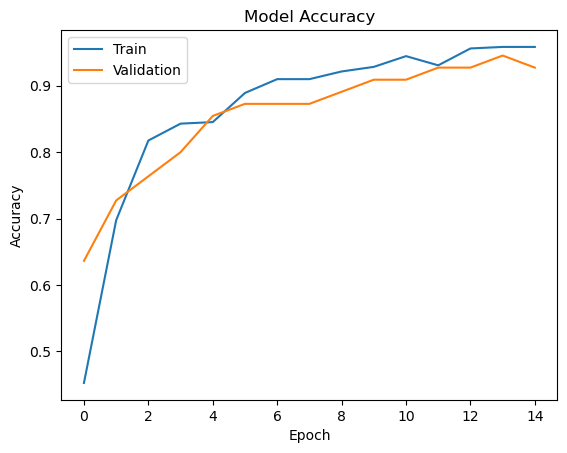

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test

In [46]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Loss on test set: {test_loss}")
print(f"Acuracy on test set: {test_accuracy}")


57/57 [==============================] - 5s 84ms/step - loss: 0.2129 - accuracy: 0.8947
Loss on test set: 0.21292714774608612
Acuracy on test set: 0.8947368264198303


./data\processed\test\carrot\image020.jpg: carrot
./data\processed\test\lemon\images (19).jpg: lemon
./data\processed\test\potato\images (49).jpg: potato
./data\processed\test\tomato\images (69).jpg: tomato


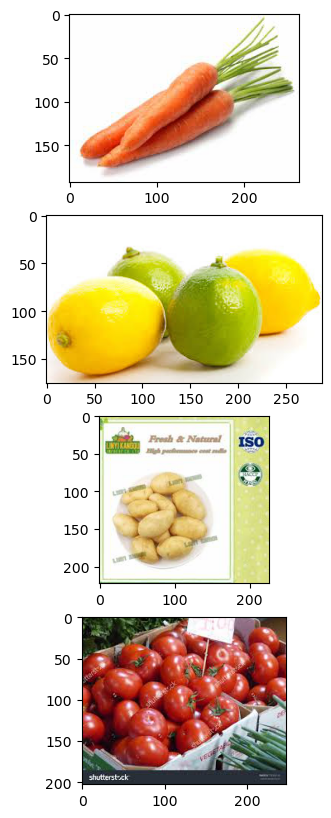

In [47]:
def predict_image(model, image):
    prediction = model.predict(image, verbose=0)
    predicted_classes = np.argmax(prediction, axis=1)
    return predicted_classes

figura, plots = plt.subplots(nrows=len(classes), ncols=1, figsize=(5, 10))

for i,cl in enumerate(classes):   
    folder = os.path.join(test_folder, cl)
    image_path = os.path.join(folder, os.listdir(folder)[3])

    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image)
    image = tf.image.resize(image, [image_size, image_size])
    image = image / 255.0

    image_array = image.numpy()
    image_array = np.expand_dims(image_array, axis=0) 
  
    predicted_classes = predict_image(model,image_array)
    
    print(f"{image_path}: {classes[predicted_classes[0]]}")

    image = PIL.Image.open(image_path)
    plots[i].imshow(image)


### Deploy

In [48]:
def prediction(image):
    image_array = tf.image.resize(image, [image_size, image_size])
    image_array /= 255.0
    
    image_array = np.expand_dims(image_array, axis=0) 
  
    predicted_classes = predict_image(model,image_array)

    return classes[predicted_classes[0]]

In [49]:
interface_gradio = gr.Interface(fn=prediction, 
                                inputs=gr.components.Image(), 
                                outputs="label").launch(share=False)

Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.
